(56571, 9)


,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f


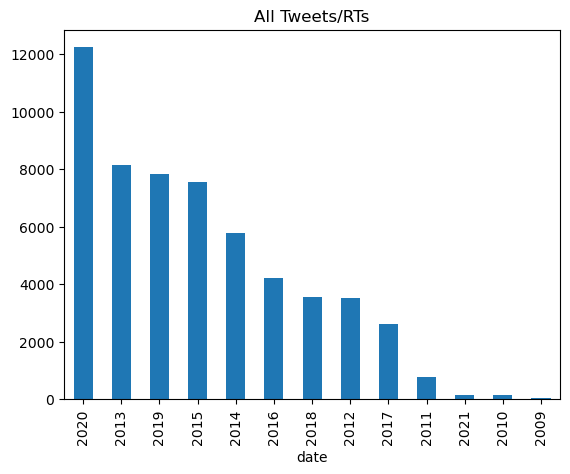

In [2]:
import pandas
import numpy as np
raw_tweets = pandas.read_csv("trump-tweets.csv")
dates  = pandas.to_datetime(raw_tweets["date"])
years = dates.apply(lambda x: x.year)
years.value_counts().plot(kind='bar', title="All Tweets/RTs")
print(raw_tweets.shape)
raw_tweets.head()

Now to clean up the data and drop unwanted features/entries, such as number of retweets, or tweets that are just media.

(46869, 9)


,text,year
0,Republicans and Democrats have both created ou...,2011
3,The Unsolicited Mail In Ballot Scam is a major...,2020
19,The threshold identification of Ballots is tur...,2020
20,"“I’m running as a proud Democrat, for the Sena...",2020
26,Nevada is turning out to be a cesspool of Fake...,2020


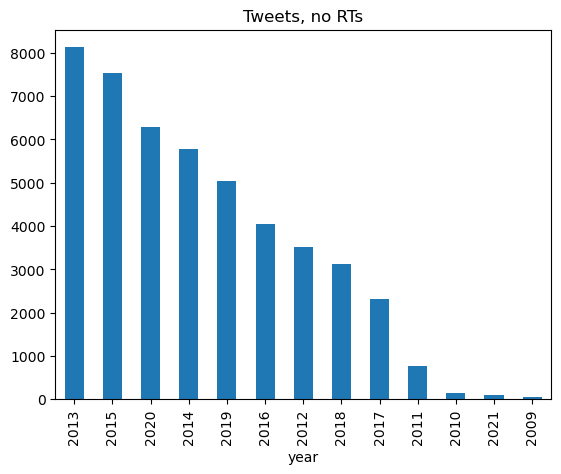

In [94]:
#converts a date to the day of the year it occurred on (0-365)
def date_to_doy(date):
    date_str = "01/01/" + str(date.year)
    yr_begin = pandas.to_datetime(date_str)
    return (date - yr_begin).days

#remove retweets
tweets = raw_tweets.drop(raw_tweets[raw_tweets["text"].str.find("RT") == 0].index)
print(tweets.shape)
tweets = tweets.drop(["id", "favorites", "retweets", "isFlagged", "isDeleted", "isRetweet", "device"], axis=1)
tweets["date"]  = pandas.to_datetime(tweets["date"])

tweets["year"] = tweets["date"].apply(lambda x: x.year)

tweets["year"].value_counts().plot(kind='bar', title="Tweets, no RTs")
# # remove entries that contain media, as these are often short, or don't convey the whole meaning of the tweet via text
tweets = tweets.drop(tweets[tweets["text"].str.find("https://t.co/") >= 0].index)
tweets["day"] = tweets["date"].apply(lambda x: date_to_doy(x))
# times are pretty randomly distributed, so we can ignore them
tweets = tweets.drop(["date"], axis=1)
tweets = tweets.drop(["day"], axis=1)
tweets.head()


<Axes: title={'center': 'Tweets, no media'}, xlabel='year'>

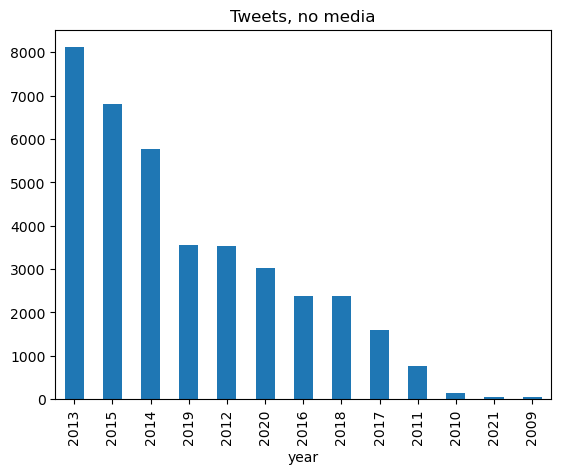

In [5]:
tweets["year"].value_counts().plot(kind='bar', title="Tweets, no media")

The first few years of tweeting were very sparse - Trump's account was barely used from 2009-2011, and Trump's account was suspended in January of 2021, so there isn't enough data to really predict those years. As a result, they are dropped. After this, we can separate the tweet features from the years to begin modeling.

(37144, 3)


<Axes: title={'center': 'Final Tweets'}, xlabel='year'>

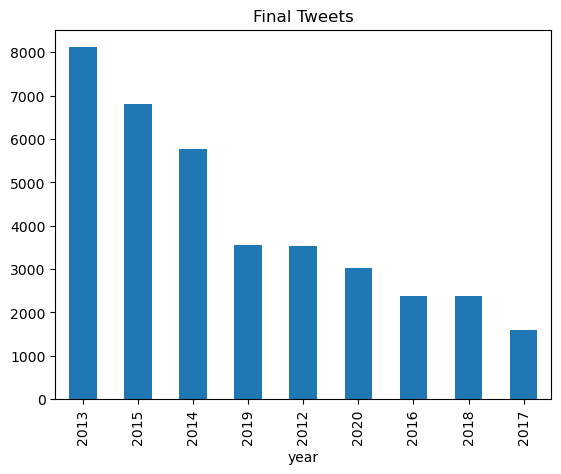

In [9]:
all_yr_twts = tweets
tweets = tweets[~tweets["year"].isin((2009, 2010, 2011, 2021))]
tweet_yrs = tweets["year"]
tweets = tweets.drop(["year"], axis=1)
print(tweets.shape)
tweet_yrs.value_counts().plot(kind='bar', title="Final Tweets")



In [48]:
tweets_text = tweets["text"]
# all_text = all_yr_twts["text"]
# all_yrs = all_yr_twts["year"]

year_divs = {}

for yr in tweet_yrs.value_counts().index:
    #no tweets before 
    if yr == 2012:
        continue
    this_yr_div = tweet_yrs.apply(lambda year: f"pre{yr}" if year < yr else f"post{yr}")
    year_divs[yr] = this_yr_div
    
years_div17 = tweet_yrs.apply(lambda yr: "pre2017" if yr < 2017 else "post2017")
print(years_div17.value_counts())

year
pre2017     26597
post2017    10547
Name: count, dtype: int64


Naive Bayes

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier as RandFor
from nltk.tokenize import TweetTokenizer
from collections import namedtuple
from sklearn.neural_network import MLPClassifier


In [51]:
# use a pipeline to do vectorizing for us, keep testing/training separate
mult_nb = MultinomialNB()
pipeline = Pipeline(steps=[('vectorizer', CountVectorizer()), ('nb', mult_nb)])
NBpredictions = cross_val_predict(pipeline, tweets_text, tweet_yrs)

NBpredictions_div17 = cross_val_predict(pipeline, tweets_text, years_div17)

print(classification_report(tweet_yrs, NBpredictions))
print(classification_report(years_div17, NBpredictions_div17))

for yr in sorted(list(year_divs.keys())):
    div_yr = year_divs[yr]
    NBpredictions_by_yr = cross_val_predict(pipeline, tweets_text, div_yr)
    print(f"{yr}: {accuracy_score(div_yr, NBpredictions_by_yr)}")


              precision    recall  f1-score   support

        2012       0.66      0.36      0.47      3522
        2013       0.50      0.58      0.54      8114
        2014       0.43      0.35      0.39      5769
        2015       0.45      0.48      0.46      6810
        2016       0.54      0.16      0.25      2382
        2017       0.57      0.02      0.04      1585
        2018       0.35      0.30      0.32      2375
        2019       0.33      0.73      0.46      3557
        2020       0.53      0.56      0.54      3030

    accuracy                           0.45     37144
   macro avg       0.48      0.39      0.39     37144
weighted avg       0.48      0.45      0.43     37144

              precision    recall  f1-score   support

    post2017       0.72      0.91      0.81     10547
     pre2017       0.96      0.86      0.91     26597

    accuracy                           0.88     37144
   macro avg       0.84      0.89      0.86     37144
weighted avg       0.89

2017's score was very low, so I tried doing some analysis on the word counts to see what trends I could find, but they weren't super informative. My guess is that Trump's first year didn't have many issues that were distinct from those that became relevant later on in his presidency. The main issues that were in correctly identified tweets were attempts to repeal the Affordable Care Act and the 2017 Tax Bill. Also present is Trump's support for Luther Strange, a primary candidate for Alabama's special Senate election that year.

In [22]:
vectorizer = CountVectorizer()
true_predictions = pandas.DataFrame(data={"true": tweet_yrs, "pred": NBpredictions})
true_predictions.head()
tp_2017 = true_predictions[true_predictions['true'] == 2017]
print(tp_2017.value_counts())


tweets_17corr = tweets["text"].loc[tp_2017[tp_2017["pred"] == 2017].index]
vect_17corr = vectorizer.fit_transform(tweets_17corr)
word_counts = vect_17corr.sum(axis=0)
vocab = vectorizer.get_feature_names_out()
word_freq = pandas.DataFrame({
    'word': vocab,
    'count': word_counts.A1  
})
# Sort by count in descending order
word_freq = word_freq.sort_values(by='count', ascending=False)
# ignore the basic common words at the top (e.g. the, and, etc)
word_freq[5:15]

true  pred
2017  2019    782
      2018    316
      2020    238
      2015     96
      2013     71
      2017     37
      2016     26
      2014     17
      2012      2
Name: count, dtype: int64


,word,count
117,great,14
202,obamacare,12
168,luther,12
14,amp,12
329,with,11
325,will,11
129,healthcare,11
203,of,11
295,tax,11
148,is,9


Random Forest

In [25]:
rf = RandFor()
pipeline = Pipeline(steps=[('vectorizer', CountVectorizer()), ('rf', rf)])
RFpredictions = cross_val_predict(pipeline, tweets_text, tweet_yrs)
print(classification_report(tweet_yrs, RFpredictions))
RFpredictions_div17 = cross_val_predict(pipeline, tweets_text, years_div17)
print(classification_report(years_div17, RFpredictions_div17))


              precision    recall  f1-score   support

        2012       0.64      0.40      0.49      3522
        2013       0.38      0.64      0.47      8114
        2014       0.39      0.26      0.31      5769
        2015       0.41      0.49      0.45      6810
        2016       0.53      0.24      0.34      2382
        2017       0.34      0.10      0.16      1585
        2018       0.48      0.19      0.28      2375
        2019       0.46      0.57      0.51      3557
        2020       0.58      0.40      0.47      3030

    accuracy                           0.43     37144
   macro avg       0.47      0.37      0.39     37144
weighted avg       0.45      0.43      0.41     37144

              precision    recall  f1-score   support

    post2017       0.92      0.68      0.78     10547
     pre2017       0.88      0.98      0.93     26597

    accuracy                           0.89     37144
   macro avg       0.90      0.83      0.85     37144
weighted avg       0.89

In [26]:
RFtrue_predictions = pandas.DataFrame(data={"true": tweet_yrs, "pred": RFpredictions})
RFtrue_predictions.head()
RFtp_2017 = RFtrue_predictions[RFtrue_predictions['true'] == 2017]
print(RFtp_2017.value_counts())


RFtweets_17corr = tweets["text"].loc[RFtp_2017[RFtp_2017["pred"] == 2017].index]

RFvect_17corr = vectorizer.fit_transform(RFtweets_17corr)
RFword_counts = RFvect_17corr.sum(axis=0)
RFvocab = vectorizer.get_feature_names_out()
RFword_freq = pandas.DataFrame({
    'word': RFvocab,
    'count': RFword_counts.A1  
})
# Sort by count in descending order
RFword_freq = RFword_freq.sort_values(by='count', ascending=False)
# ignore the basic common words at the top (e.g. the, and, etc)
RFword_freq[5:15]

true  pred
2017  2013    644
      2019    228
      2017    162
      2020    157
      2015    155
      2016     82
      2018     80
      2014     45
      2012     32
Name: count, dtype: int64


,word,count
328,fake,58
647,news,54
477,is,53
351,for,52
928,tax,48
1045,will,39
1050,with,38
391,great,33
232,cuts,33
674,on,33


Neural Network

In [28]:
# in order to shorten running time, a regular test/train split is used rather than cross validation. 
text_train, text_test, yr_train, yr_test = train_test_split(tweets_text, tweet_yrs, random_state=2)
mlp = MLPClassifier()
pipeline = Pipeline(steps=[('vectorizer', CountVectorizer()), ('mlp', mlp)])
pipeline.fit(text_train, yr_train)
MLPpredictions = pipeline.predict(text_test)
print(classification_report(yr_test, MLPpredictions))


              precision    recall  f1-score   support

        2012       0.61      0.59      0.60       841
        2013       0.60      0.59      0.60      2023
        2014       0.51      0.52      0.51      1428
        2015       0.61      0.61      0.61      1673
        2016       0.53      0.50      0.51       633
        2017       0.37      0.36      0.37       419
        2018       0.47      0.47      0.47       607
        2019       0.53      0.58      0.55       888
        2020       0.60      0.60      0.60       774

    accuracy                           0.56      9286
   macro avg       0.54      0.54      0.54      9286
weighted avg       0.56      0.56      0.56      9286



In [38]:
text_train17, text_test17, yr_train17, yr_test17 = train_test_split(tweets_text, years_div17, random_state=2)
pipeline = Pipeline(steps=[('vectorizer', CountVectorizer()), ('mlp', mlp)])
pipeline.fit(text_train17, yr_train17)
MLPpredictions17 = pipeline.predict(text_test17)
print(classification_report(yr_test17, MLPpredictions17))

              precision    recall  f1-score   support

    post2017       0.84      0.89      0.86      2688
     pre2017       0.95      0.93      0.94      6598

    accuracy                           0.92      9286
   macro avg       0.90      0.91      0.90      9286
weighted avg       0.92      0.92      0.92      9286



In [36]:
MLPtrue_predictions = pandas.DataFrame(data={"true": yr_test, "pred": MLPpredictions})
MLPtp_2017 = MLPtrue_predictions[MLPtrue_predictions['true'] == 2017]
print(MLPtp_2017.value_counts())


MLPtweets_17corr = tweets["text"].loc[MLPtp_2017[MLPtp_2017["pred"] == 2017].index]

MLPvect_17corr = vectorizer.fit_transform(MLPtweets_17corr)
MLPword_counts = MLPvect_17corr.sum(axis=0)
MLPvocab = vectorizer.get_feature_names_out()
MLPword_freq = pandas.DataFrame({
    'word': MLPvocab,
    'count': MLPword_counts.A1  
})
# Sort by count in descending order
MLPword_freq = MLPword_freq.sort_values(by='count', ascending=False)
# ignore the basic common words at the top (e.g. the, and, etc)
MLPword_freq[5:15]
#nothing really special in the results

true  pred
2017  2017    152
      2018     68
      2019     59
      2020     46
      2016     30
      2013     27
      2015     18
      2014     12
      2012      7
Name: count, dtype: int64


,word,count
485,in,57
365,for,53
1105,will,50
93,be,42
58,amp,39
409,great,38
71,are,35
1111,with,30
986,that,28
975,tax,27


2017 Value Counts

In [92]:
df_2017 = pandas.DataFrame({"NB": tp_2017.value_counts().reset_index(0, drop=True), "RF": RFtp_2017.value_counts().reset_index(0, drop=True), "MLP": MLPtp_2017.value_counts().reset_index(0, drop=True)})
print(df_2017)

pred
2019    782
2018    316
2020    238
2015     96
2013     71
2017     37
2016     26
2014     17
2012      2
Name: count, dtype: int64
true  pred
2017  2013    644
      2019    228
      2017    162
      2020    157
      2015    155
      2016     82
      2018     80
      2014     45
      2012     32
Name: count, dtype: int64
true  pred
2017  2017    152
      2018     68
      2019     59
      2020     46
      2016     30
      2013     27
      2015     18
      2014     12
      2012      7
Name: count, dtype: int64
       NB   RF  MLP
pred               
2012    2   32    7
2013   71  644   27
2014   17   45   12
2015   96  155   18
2016   26   82   30
2017   37  162  152
2018  316   80   68
2019  782  228   59
2020  238  157   46
